# Вариант 1

Загрузить файл с информацией о диабетах и построить модель классификации на основе имеющихся данных.

In [76]:
import pandas as pd

df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

Создаю pytorch датасет из тензоров

In [78]:
class DiabetesDataset(Dataset):

    def __init__(self):
        df = pd.read_csv("diabetes.csv")
        self.x = torch.from_numpy(df[df.columns.drop("Outcome")].to_numpy()).to(torch.float)
        self.y = torch.from_numpy(df["Outcome"].to_numpy()).to(torch.long)
        self.n_classes = len(self.y.unique())

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [79]:
dataset = DiabetesDataset()
dataset.x.size(), dataset.y.size(), dataset.n_classes

(torch.Size([768, 8]), torch.Size([768]), 2)

In [80]:
torch.manual_seed(0)
train_size = round(0.8 * len(dataset))  # 80/20 - стандартно
train_dataset, test_dataset = random_split(dataset, lengths=(train_size, len(dataset) - train_size))
len(train_dataset), len(test_dataset)

(614, 154)

In [81]:
class Classificator(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.classifier = nn.Sequential(  # простой полносвязный слой с Dropout(0.5)
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, out_features),
        )

    def forward(self, x):
        return self.classifier(x)

In [82]:
torch.manual_seed(0)

net = Classificator(dataset.x.size(1), dataset.n_classes)
loss_fn = nn.CrossEntropyLoss()
# подбором 0.005 - неплохое значение
optimizer = optim.Adam(net.parameters(), lr=0.005)

# batch_size=16, batch_size=32, batch_size=8 показывают себя ~одинаково
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

Classificator(
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [83]:
epochs = 40

train_losses = []
for epoch in range(epochs):
    # ===================== TRAIN LOOP =====================
    net.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    avg_loss = 0
    for batch, (x, y) in enumerate(train_dataloader):
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss
    train_losses.append((avg_loss / num_batches).item())

    # ===================== TEST LOOP =====================
    net.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    avg_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_dataloader:
            pred = net(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).sum().item()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Epoch {epoch + 1:>2}: accuracy: {accuracy:>4f}, avg loss: {avg_loss:>8f}")

Epoch  1: accuracy: 0.714286, avg loss: 1.325124
Epoch  2: accuracy: 0.629870, avg loss: 2.638500
Epoch  3: accuracy: 0.733766, avg loss: 3.921379
Epoch  4: accuracy: 0.649351, avg loss: 1.079565
Epoch  5: accuracy: 0.662338, avg loss: 0.939651
Epoch  6: accuracy: 0.577922, avg loss: 1.280135
Epoch  7: accuracy: 0.675325, avg loss: 1.030174
Epoch  8: accuracy: 0.636364, avg loss: 1.474939
Epoch  9: accuracy: 0.668831, avg loss: 1.256614
Epoch 10: accuracy: 0.642857, avg loss: 0.922911
Epoch 11: accuracy: 0.714286, avg loss: 0.857637
Epoch 12: accuracy: 0.668831, avg loss: 0.821980
Epoch 13: accuracy: 0.681818, avg loss: 1.098185
Epoch 14: accuracy: 0.694805, avg loss: 1.079787
Epoch 15: accuracy: 0.720779, avg loss: 0.737223
Epoch 16: accuracy: 0.662338, avg loss: 0.868354
Epoch 17: accuracy: 0.701299, avg loss: 0.821456
Epoch 18: accuracy: 0.740260, avg loss: 0.751089
Epoch 19: accuracy: 0.727273, avg loss: 0.689190
Epoch 20: accuracy: 0.727273, avg loss: 0.681626
Epoch 21: accuracy: 

Эпох многовато, видно, что у модели не получается преодолеть loss~=0.8

Динамика обучения модели:

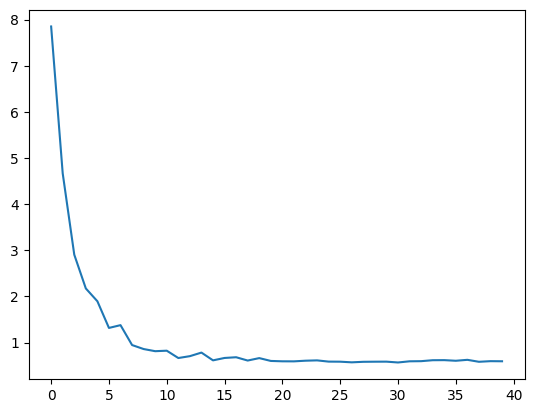

In [84]:
plt.plot(torch.arange(len(train_losses)), train_losses);

In [85]:
net.eval()

x_test, y_test = next(iter(test_dataloader))
y_pred = net(x_test).argmax(1)
print(metrics.classification_report(y_true=y_test, y_pred=y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       102
           1       0.63      0.33      0.43        52

    accuracy                           0.71       154
   macro avg       0.68      0.61      0.62       154
weighted avg       0.69      0.71      0.68       154



Не очень хорошо получилось, что мы хуже предсказываем факт болезни (произошло это из-за несбалансированности классов), но в целом точность модели терпимая (не 50/50).

80%/20% - стандартное разбиение выборки.